In [1]:
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(useful)) 
suppressPackageStartupMessages(library(ggplot2)) 
suppressPackageStartupMessages(library(dplyr)) 
suppressPackageStartupMessages(library(limma)) 
suppressPackageStartupMessages(library(EnhancedVolcano)) 
suppressPackageStartupMessages(library(biomaRt)) 


Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




In [2]:
data1 <- read.csv("bulk/iGlut_pre_merged_symbols.tsv",sep="\t",header=T,quote="",row.names=1)
corner(data1) 
meta1 <- read.csv("bulk/prepat_sample_meta.tsv",sep="\t",header=T,row.names=1,quote="")
row.names(meta1) <- paste0("iGlut_pre_",row.names(meta1))
meta1$TF <- 'Glut'

,iGlut_pre_1,iGlut_pre_10,iGlut_pre_11,iGlut_pre_12,iGlut_pre_13
,<int>,<int>,<int>,<int>,<int>
A1BG,16,16,24,4,15
A1BG-AS1,4,13,7,8,3
A1CF,0,0,0,0,0
A2M,6,6,7,2,9
A2M-AS1,6,0,0,10,4


In [3]:
data2 <- read.csv("bulk/iGABA_pre_merged_symbols.tsv",sep="\t",header=T,quote="",row.names=1)
corner(data2) 
meta2 <- read.csv("bulk/prepat_sample_meta.tsv",sep="\t",header=T,row.names=1,quote="")
row.names(meta2) <- paste0("iGABA_pre_",row.names(meta2))
meta2$TF <- 'GABA'

,iGABA_pre_22,iGABA_pre_1,iGABA_pre_23,iGABA_pre_21,iGABA_pre_93
,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,0,5,0,0
5_8S_rRNA,0,0,0,0,0
7SK,1,1,0,0,0
A1BG,0,0,1,0,0
A1BG-AS1,0,0,0,1,0


In [4]:
shared_genes <- intersect(row.names(data1),row.names(data2))

In [5]:
data1 <- data1[shared_genes,]
data2 <- data2[shared_genes,]

In [6]:
data <- cbind(data1,data2)

In [7]:
meta <- rbind(meta1,meta2)

              counts
iGlut_pre_72     836
iGABA_pre_24  169341
iGABA_pre_23  277132
iGABA_pre_33  472326
iGABA_pre_66  984689
iGABA_pre_74  988182
iGABA_pre_30 1041668
iGABA_pre_68 1164674
iGABA_pre_20 1230590
iGlut_pre_25 1447814
iGABA_pre_67 1511605
iGABA_pre_13 1579470
iGABA_pre_14 1594793
iGABA_pre_9  1664473
iGABA_pre_31 1675120
iGABA_pre_45 1712954
iGABA_pre_37 1716685
iGlut_pre_71 1732770
iGABA_pre_65 1739064
iGABA_pre_15 1807716


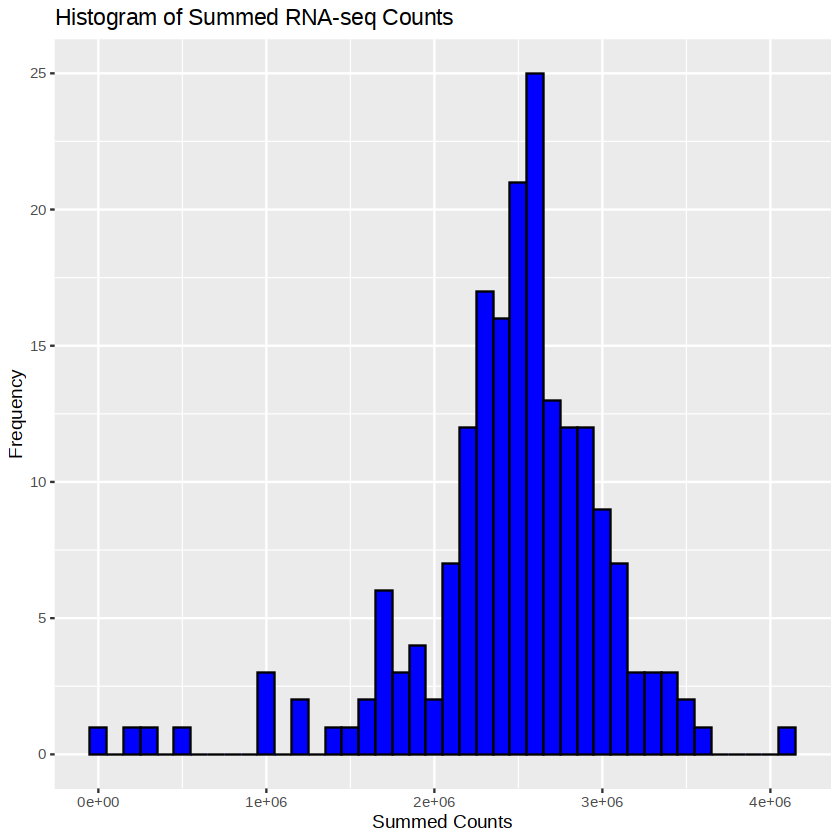

In [8]:

# Load your dataset
# Replace 'your_dataset.csv' with the path to your RNA-seq counts file
# and make sure the column containing counts is correctly specified.

# Assuming the counts are in a column named 'counts'
# Adjust 'counts' to the actual column name in your dataset
counts <- colSums(data)
# Create a dataframe from the counts for easier manipulation and plotting
counts_df <- data.frame(counts = counts)

# Plot a histogram of the counts
ggplot(counts_df, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency') +
  facet_wrap(~ TF)

# Display the lowest count values
lowest_counts <- counts_df %>% 
  arrange(counts) %>% 
  head(20)  # Displaying the 10 lowest counts; adjust as needed

print(lowest_counts)


In [12]:
# Define the minimum count threshold
min_count_threshold <- 1500000  # Replace with your desired threshold

# Filter out samples (columns) with fewer than the minimum threshold counts
filtered_data <- data[, colSums(data) >= min_count_threshold]
filtered_meta <- meta[colSums(data) >= min_count_threshold,]


In [13]:
dim(filtered_meta)

[1] 182  16

In [14]:
dim(filtered_data)

[1] 36030   182

In [18]:
deseq2.colData <- data.frame(row.names=colnames(filtered_data))
#deseq2.colData$pattern <- 'pre'


deseq2.colData <- filtered_meta
deseq2.colData['sums'] <- colSums(filtered_data)

In [19]:
corner(deseq2.colData)

,Sample,AP_axis,DV_axis,Basal_media,M_XAV
,<int>,<chr>,<chr>,<chr>,<dbl>
iGlut_pre_0,1,XAV_3,BMP4_3,NIM,5.0
iGlut_pre_1,2,XAV_3_FGF8,BMP4_3,NIM,5.0
iGlut_pre_2,3,XAV_1,BMP4_3,NIM,0.2
iGlut_pre_3,4,ctrl,BMP4_3,NIM,0.0
iGlut_pre_4,5,XAV_3,BMP4_1,NIM,5.0


In [20]:
#colData$group <- factor(colData$group)

columns_to_factor <- c("M_NIM","M_N2B27_2Si","M_N2B27_SB_CHIR","Basal_media",'TF')
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(columns_to_factor)), factor)

numeric_columns_to_scale <- c("M_XAV","M_CHIR","M_RA","M_FGF8","M_BMP4","M_SHH")
# Scale the specified numeric columns
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(numeric_columns_to_scale)), ~ scale(log(. + 1)))



In [21]:
deseq2.colData

,Sample,AP_axis,DV_axis,Basal_media,M_XAV,M_CHIR,M_RA,M_FGF8,M_BMP4,M_SHH,M_PM,M_CycA,M_NIM,M_N2B27_2Si,M_N2B27_SB_CHIR,TF,sums
,<int>,<chr>,<chr>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>
iGlut_pre_0,1,XAV_3,BMP4_3,NIM,1.7610934,-0.5884176,-0.4227954,-0.7080694,1.9362351,-0.7491077,0,0,1,0,0,Glut,2649695
iGlut_pre_1,2,XAV_3_FGF8,BMP4_3,NIM,1.7610934,-0.5884176,-0.4227954,1.4045311,1.9362351,-0.7491077,0,0,1,0,0,Glut,2033525
iGlut_pre_2,3,XAV_1,BMP4_3,NIM,-0.3579833,-0.5884176,-0.4227954,-0.7080694,1.9362351,-0.7491077,0,0,1,0,0,Glut,2338980
iGlut_pre_3,4,ctrl,BMP4_3,NIM,-0.5980381,-0.5884176,-0.4227954,-0.7080694,1.9362351,-0.7491077,0,0,1,0,0,Glut,2373124
iGlut_pre_4,5,XAV_3,BMP4_1,NIM,1.7610934,-0.5884176,-0.4227954,-0.7080694,0.5506548,-0.7491077,0,0,1,0,0,Glut,2552353
iGlut_pre_5,6,XAV_3_FGF8,BMP4_1,NIM,1.7610934,-0.5884176,-0.4227954,1.4045311,0.5506548,-0.7491077,0,0,1,0,0,Glut,2310287
iGlut_pre_6,7,XAV_1,BMP4_1,NIM,-0.3579833,-0.5884176,-0.4227954,-0.7080694,0.5506548,-0.7491077,0,0,1,0,0,Glut,2553842
iGlut_pre_7,8,ctrl,BMP4_1,NIM,-0.5980381,-0.5884176,-0.4227954,-0.7080694,0.5506548,-0.7491077,0,0,1,0,0,Glut,2583080
iGlut_pre_8,9,XAV_3,CycA,NIM,1.7610934,-0.5884176,-0.4227954,-0.7080694,-0.6094153,-0.7491077,0,1,1,0,0,Glut,2430526


In [25]:
total <- filtered_data
rownames(deseq2.colData) <- colnames(total)
dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ TF+M_RA+M_XAV+M_CHIR+M_FGF8+M_BMP4+M_SHH+Basal_media)

#dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ M_RA)

In [26]:
colnames(deseq2.colData)

[1] "Sample"          "AP_axis"         "DV_axis"         "Basal_media"    
 [5] "M_XAV"           "M_CHIR"          "M_RA"            "M_FGF8"         
 [9] "M_BMP4"          "M_SHH"           "M_PM"            "M_CycA"         
[13] "M_NIM"           "M_N2B27_2Si"     "M_N2B27_SB_CHIR" "TF"             
[17] "sums"

In [27]:
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# Run Analysis
dds <- DESeq(dds)
res <- results(dds)
res <- res[order(rownames(res)), ]

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

1 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest



In [109]:
table(mcols(dds)$betaConv)


FALSE  TRUE 
    1 26045 

In [28]:
#save median normalised counts
normalized_counts <- counts(dds, normalized=TRUE)
#write.table(normalized_counts, file="bulk/DESEQ2_norm_counts_stranded.tsv", sep="\t", quote=F, col.names=NA) 

In [30]:
vsd <- vst(dds, blind=FALSE)
#rld <- rlog(dds, blind=FALSE) 

In [32]:
mat <- assay(vsd)
mm <- model.matrix(~M_RA+M_XAV+M_CHIR+M_FGF8+M_BMP4+M_SHH+Basal_media, colData(vsd))
mat <- limma::removeBatchEffect(mat, batch=vsd$TF, design=mm)
assay(vsd) <- mat

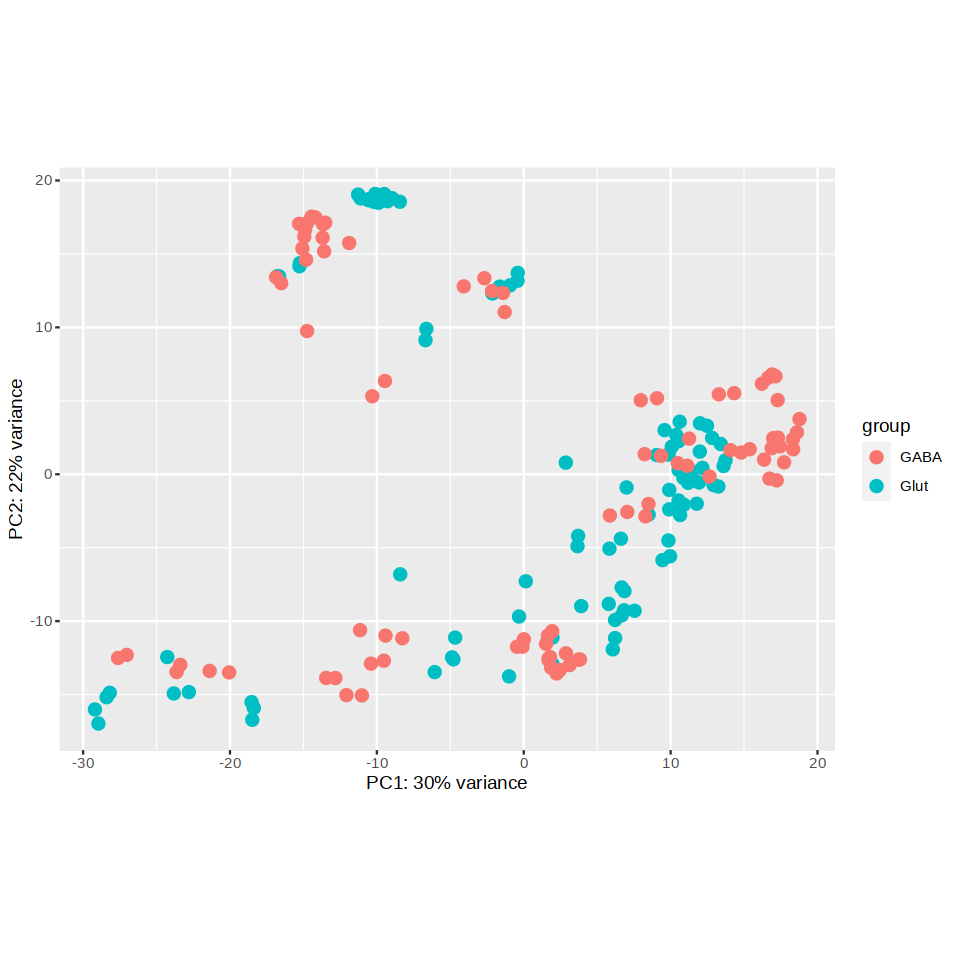

In [99]:
plotPCA(vsd,intgroup=c('TF'))

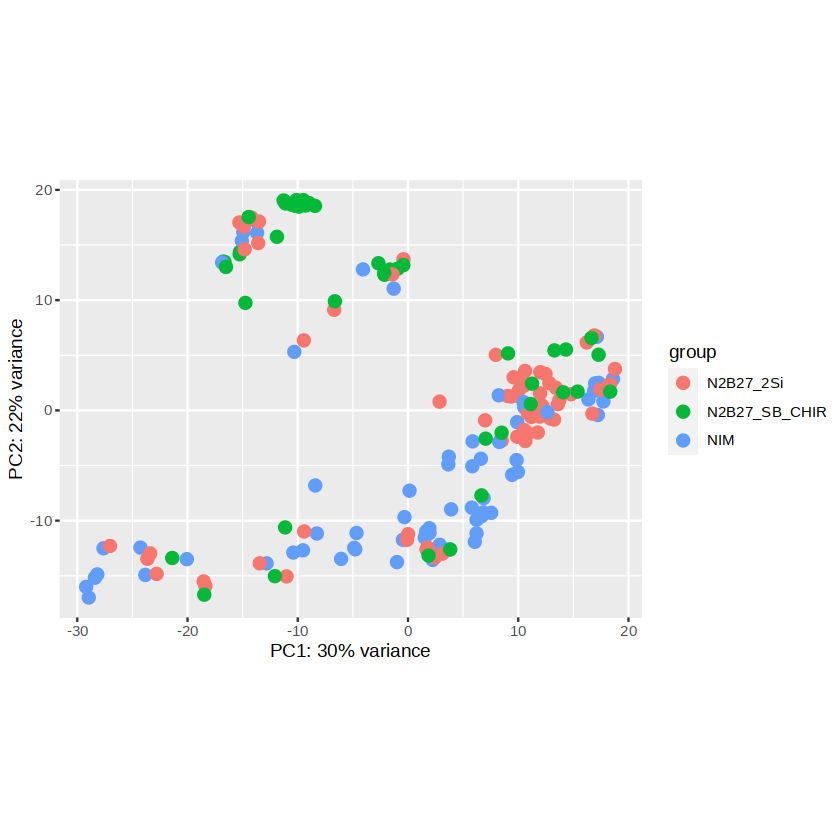

In [36]:
plotPCA(vsd,intgroup=c('Basal_media'))

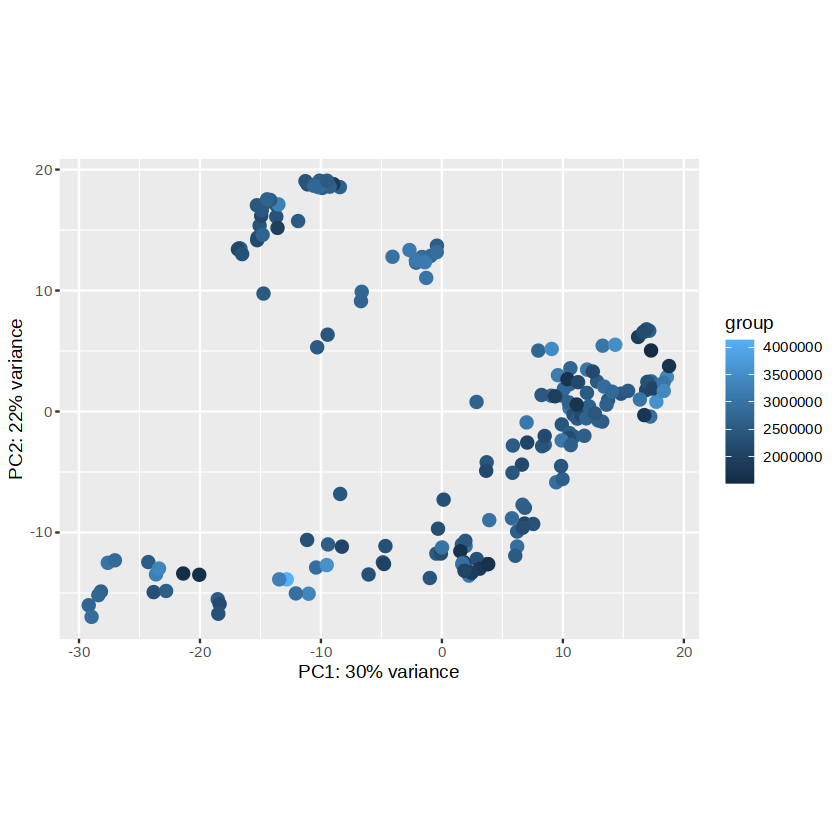

In [37]:
pca_df <- vsd
ntop <- 1000
plotPCA(object = pca_df,intgroup=c('sums'))

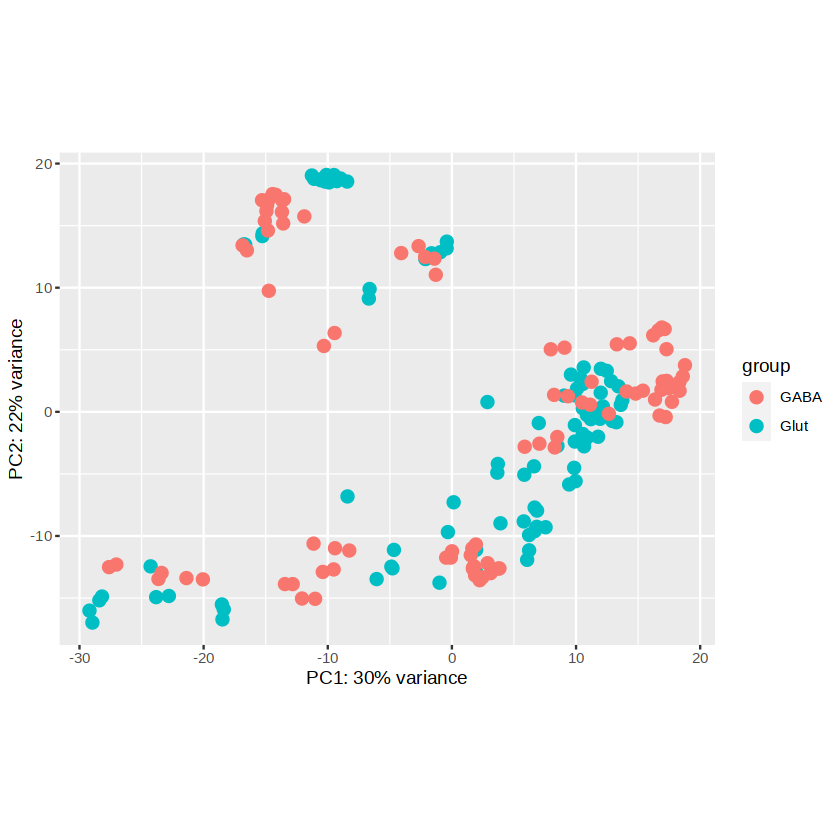

In [38]:
plotPCA(object = pca_df,intgroup=c('TF'))

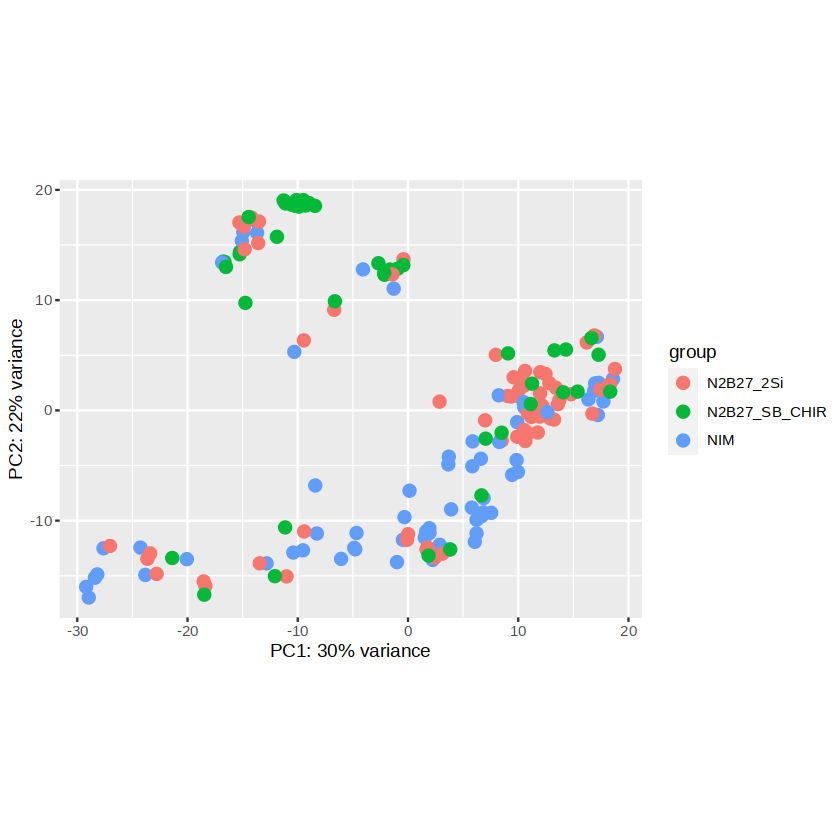

In [39]:
plotPCA(object = pca_df,intgroup=c('Basal_media'))

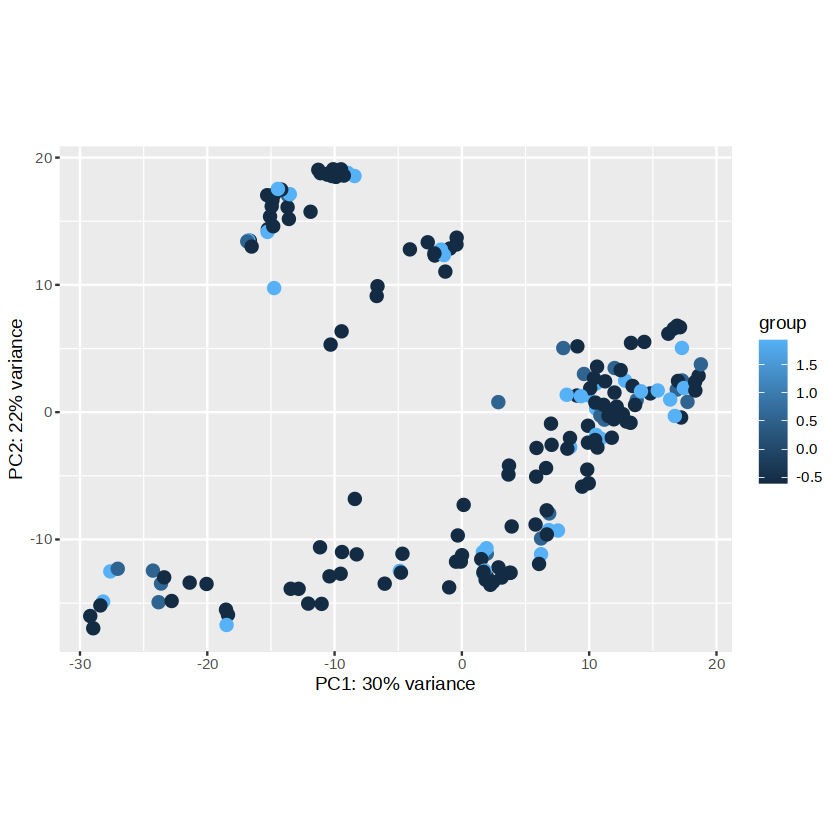

In [40]:
plotPCA(object = pca_df,intgroup=c('M_BMP4'))

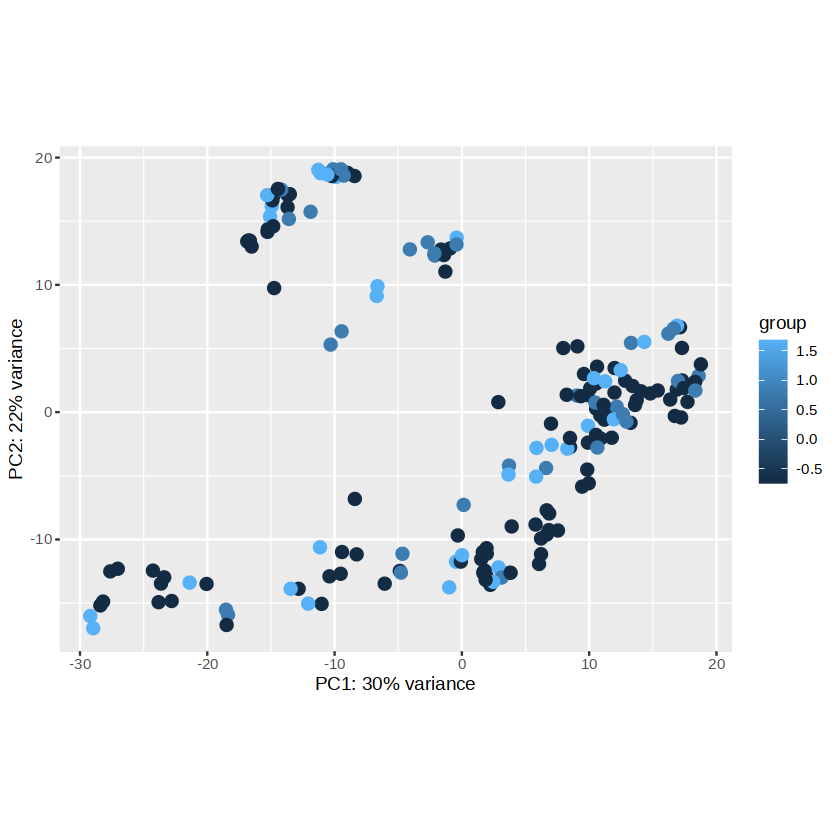

In [41]:
plotPCA(object = pca_df,intgroup=c('M_SHH'))

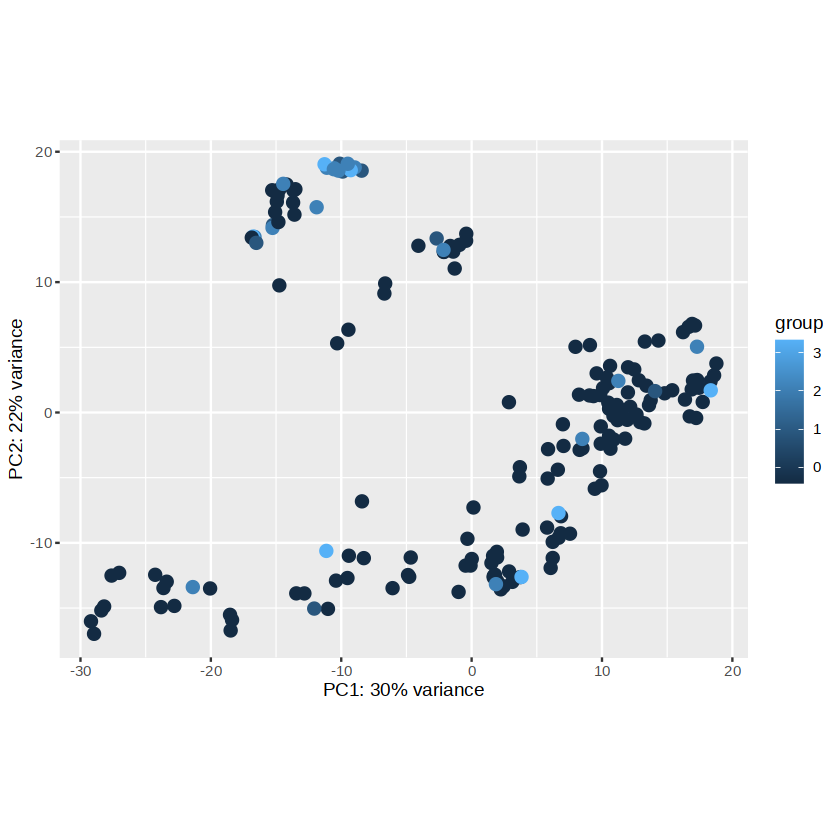

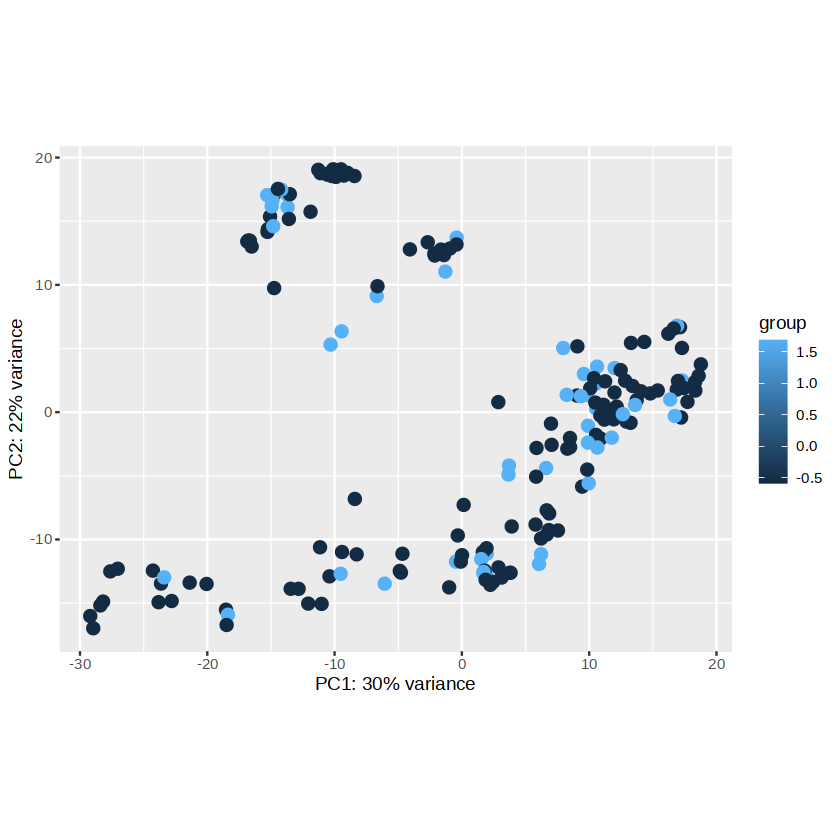

In [42]:
plotPCA(object = pca_df,intgroup=c('M_RA'))
plotPCA(object = pca_df,intgroup=c('M_CHIR'))

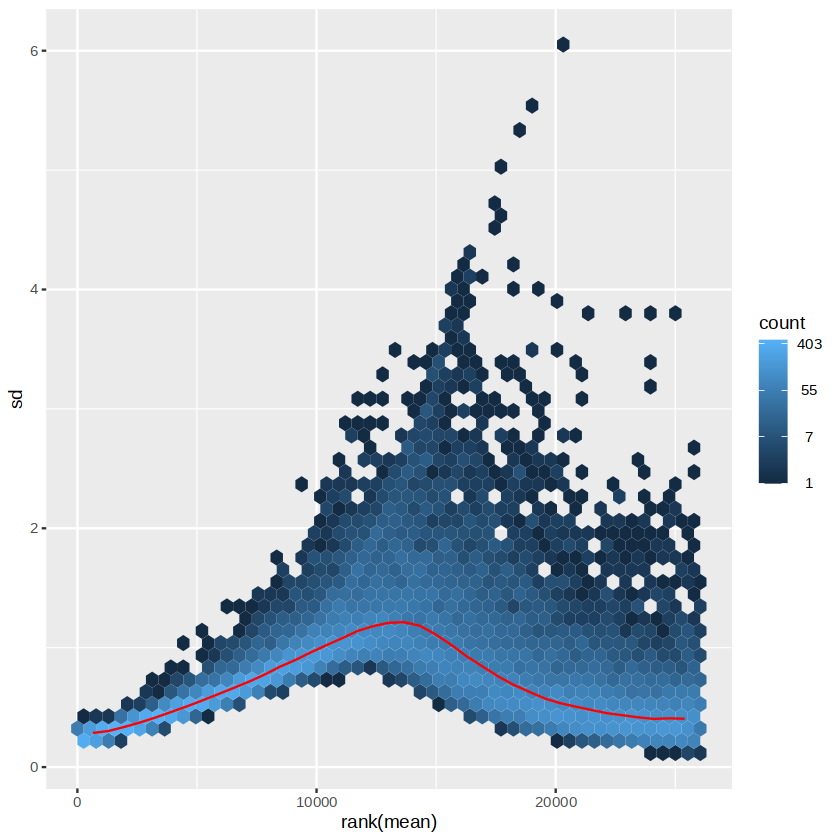

In [43]:
# this gives log2(n + 1)
ntd <- normTransform(dds)
library("vsn")
meanSdPlot(assay(ntd)) 

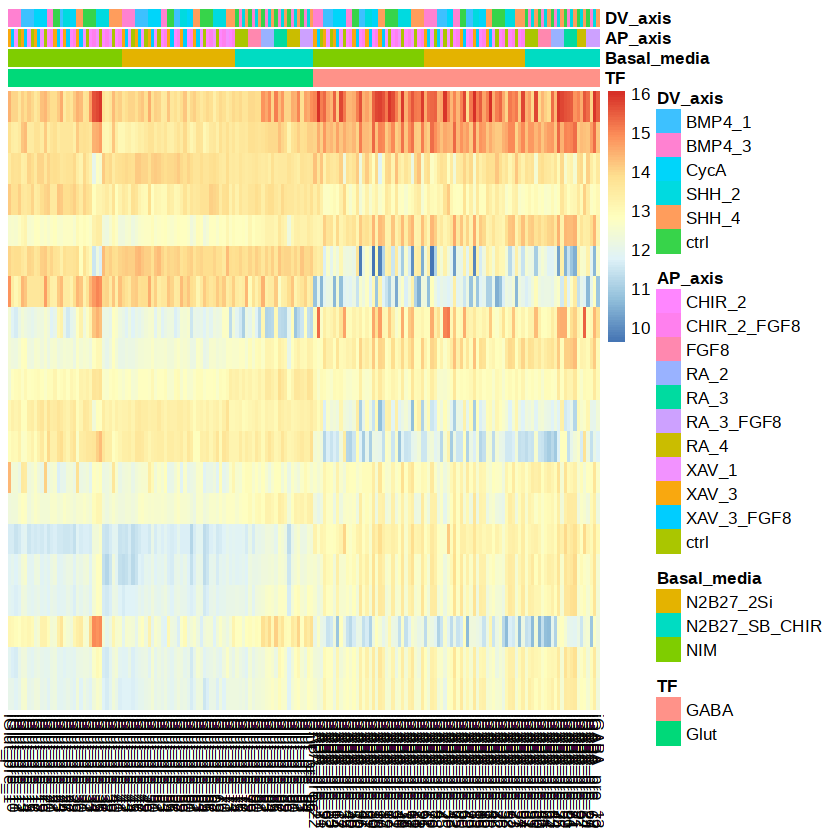

In [44]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("TF","Basal_media","AP_axis","DV_axis")])
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

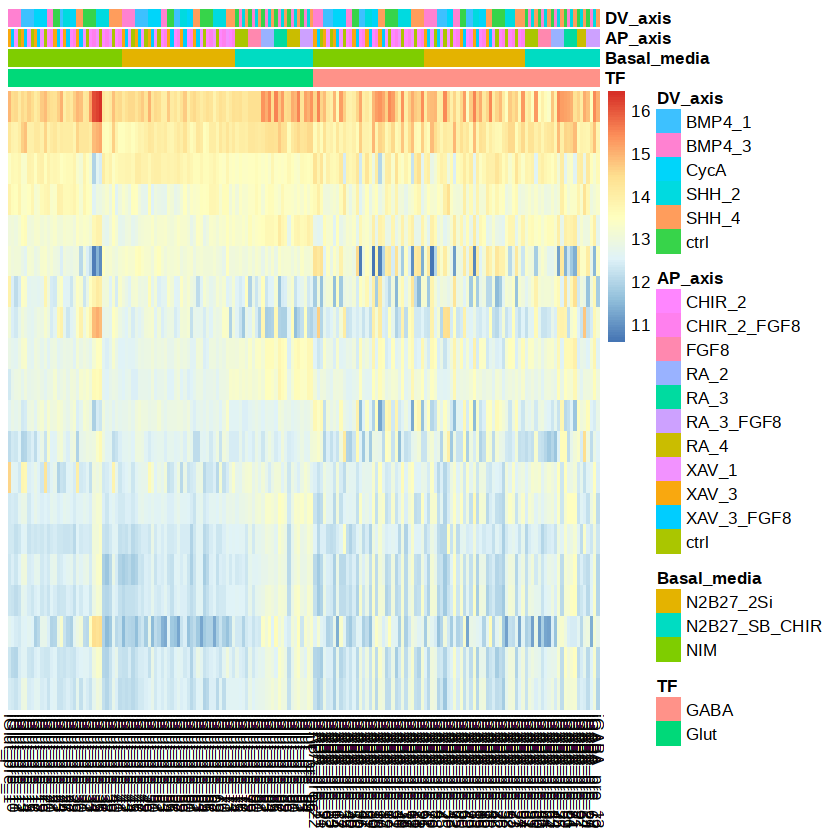

In [45]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("TF","Basal_media","AP_axis","DV_axis")])
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

In [46]:
sampleDists <- dist(t(assay(vsd)))

In [51]:
library(repr)



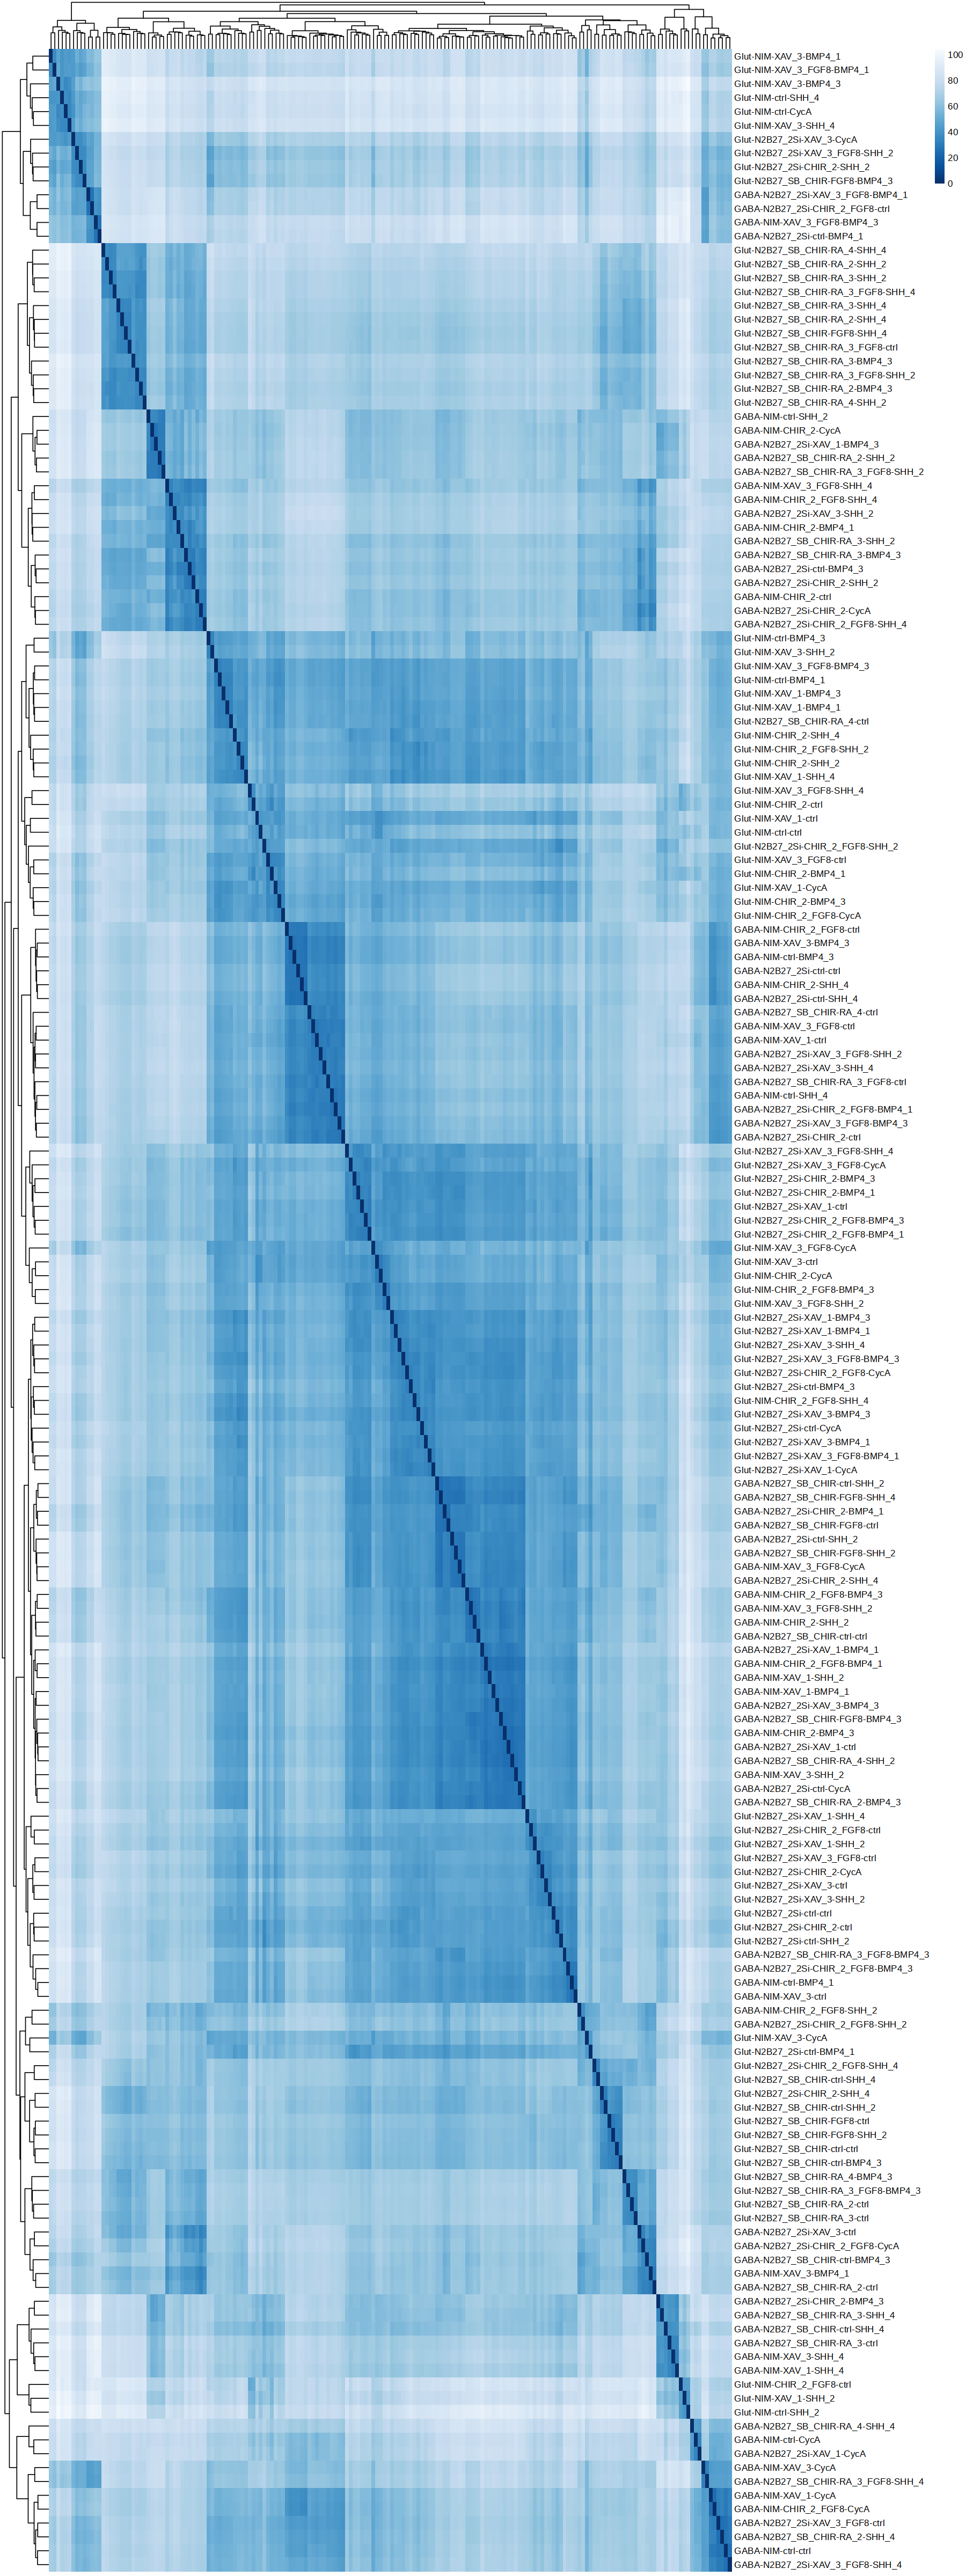

In [54]:
library("RColorBrewer")
sampleDistMatrix <- as.matrix(sampleDists)

rownames(sampleDistMatrix) <- paste(vsd$TF,vsd$Basal_media, vsd$AP_axis, vsd$DV_axis, sep="-")
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

# Set plot size
options(repr.plot.width=15, repr.plot.height=40)

pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

In [67]:
colnames(mm)

[1] "(Intercept)"              "M_RA"                    
[3] "M_XAV"                    "M_CHIR"                  
[5] "M_FGF8"                   "M_BMP4"                  
[7] "M_SHH"                    "Basal_mediaN2B27_SB_CHIR"
[9] "Basal_mediaNIM"

In [80]:
resAshT

log2 fold change (MMSE): M RA 
Wald test p-value: M RA 
DataFrame with 26046 rows and 5 columns
          baseMean log2FoldChange     lfcSE    pvalue      padj
         <numeric>      <numeric> <numeric> <numeric> <numeric>
A1BG     11.078487    0.000951472 0.0417937 0.9546671  0.983994
A1BG-AS1  3.003253   -0.022025185 0.0565259 0.1953668  0.495439
A1CF      0.314303    0.001924723 0.0674353 0.8393419        NA
A2M       4.446005    0.068560869 0.0942524 0.0159569  0.150561
A2M-AS1   3.967147   -0.006915710 0.0466550 0.6472442  0.843689
...            ...            ...       ...       ...       ...
ZYG11A     8.57726     0.02341255 0.0625491 0.1669396  0.462168
ZYG11B   115.37802    -0.00606248 0.0237642 0.7375706  0.887511
ZYX      175.03781     0.07047382 0.0834436 0.0128983  0.137026
ZZEF1     36.65814     0.00902080 0.0305574 0.6531622  0.847524
ZZZ3     302.21323    -0.02490163 0.0176660 0.0907511  0.350278

In [73]:
res_M_RA <- results(dds, name = "M_RA")
resAshT <- lfcShrink(dds,res=res_M_RA, coef=2, type="ashr", lfcThreshold=1)

In [102]:
cname <- "M_CHIR"
res_M_RA <- results(dds, name = cname)
resApe = lfcShrink(dds,res=res_M_RA,coef = cname,type="apeglm", lfcThreshold=1)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

computing FSOS 'false sign or small' s-values (T=1)



In [106]:
resApe

log2 fold change (MAP): M CHIR 
 
DataFrame with 26046 rows and 4 columns
          baseMean log2FoldChange      lfcSE    svalue
         <numeric>      <numeric>  <numeric> <numeric>
A1BG     11.078487   -0.000584181 0.00933743  0.938416
A1BG-AS1  3.003253   -0.000272153 0.00932950  0.939425
A1CF      0.314303    0.000120784 0.00934962  0.940402
A2M       4.446005    0.000619178 0.00934987  0.941348
A2M-AS1   3.967147    0.000363301 0.00933816  0.942265
...            ...            ...        ...       ...
ZYG11A     8.57726   -0.000542641 0.00935357  0.999858
ZYG11B   115.37802    0.000633110 0.00894191  0.999858
ZYX      175.03781   -0.002916402 0.00998571  0.999858
ZZEF1     36.65814   -0.002135274 0.00947873  0.999858
ZZZ3     302.21323    0.019338482 0.02287828  0.999858

In [105]:
res_M_RA

log2 fold change (MLE): M CHIR 
Wald test p-value: M CHIR 
DataFrame with 26046 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat     pvalue      padj
         <numeric>      <numeric> <numeric> <numeric>  <numeric> <numeric>
A1BG     11.078487     -0.0683902 0.0988031 -0.692187   0.488820  0.999957
A1BG-AS1  3.003253     -0.0736893 0.1245498 -0.591645   0.554088  0.999957
A1CF      0.314303      0.1309667 0.4568507  0.286673   0.774363  0.999957
A2M       4.446005      0.0165454 0.1159063  0.142748   0.886489  0.999957
A2M-AS1   3.967147      0.0780098 0.1346004  0.579566   0.562208  0.999957
...            ...            ...       ...       ...        ...       ...
ZYG11A     8.57726    -0.13051017 0.1459803 -0.894026 0.37130807  0.999957
ZYG11B   115.37802     0.00616459 0.0294312  0.209458 0.83409083  0.999957
ZYX      175.03781    -0.28521676 0.0926346 -3.078945 0.00207735  0.490978
ZZEF1     36.65814    -0.05092152 0.0434352 -1.172357 0.24105376  0.999957
Z

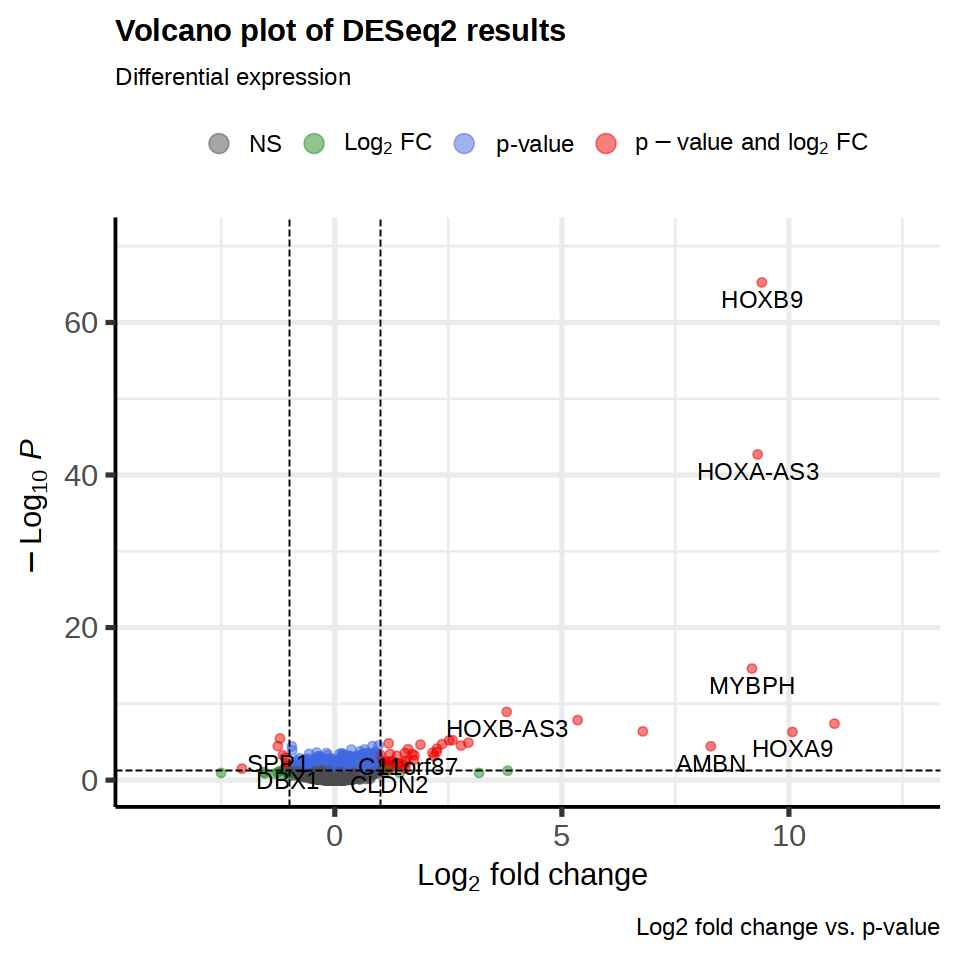

In [103]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



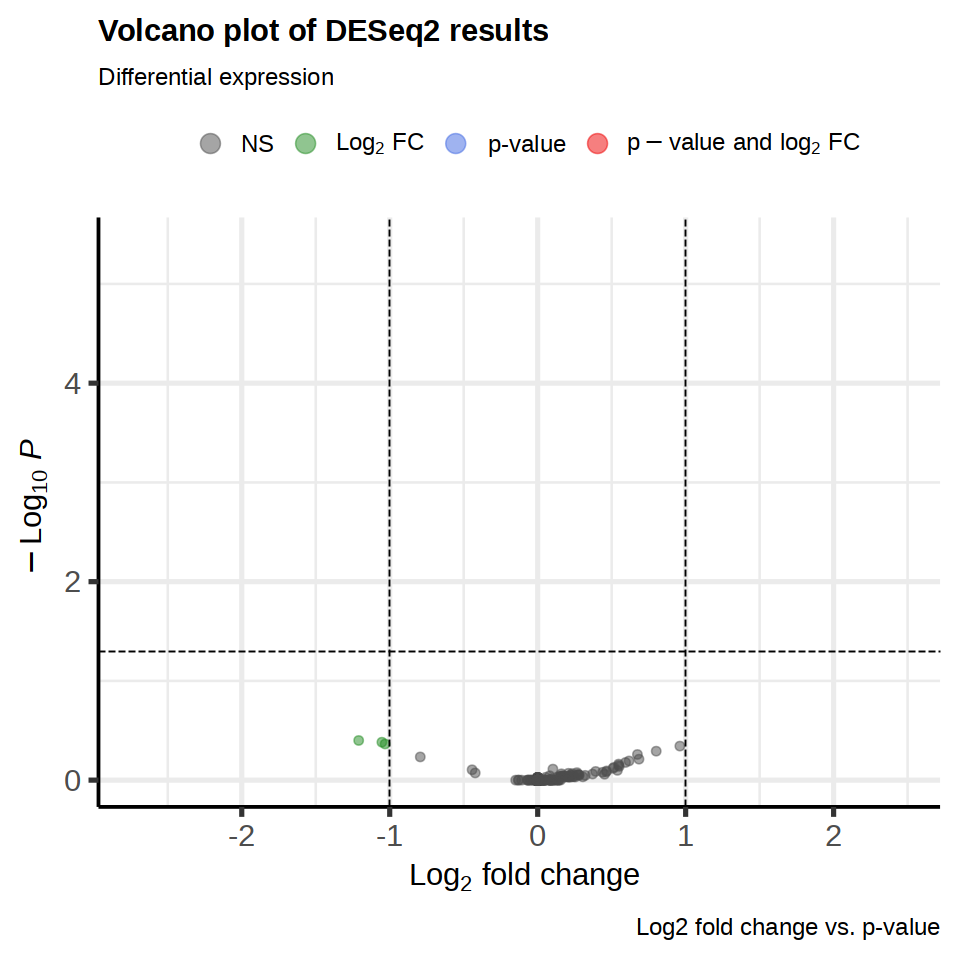

In [104]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



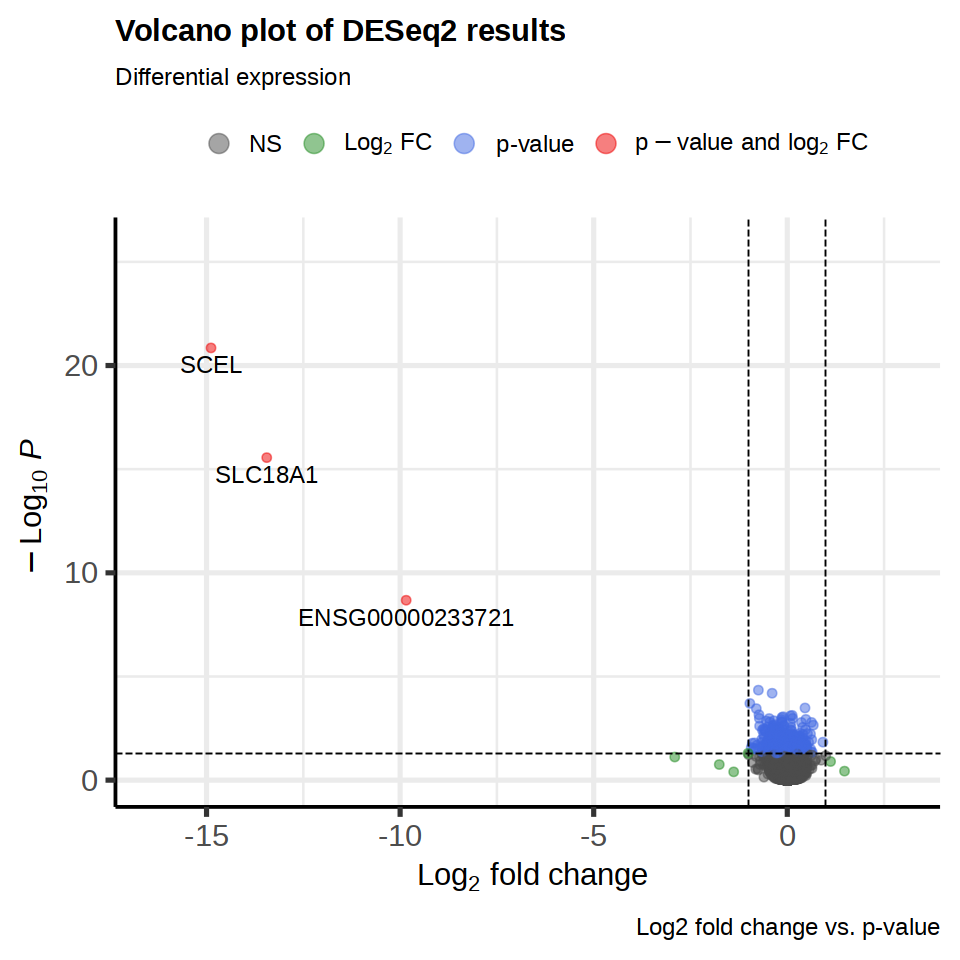

In [98]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



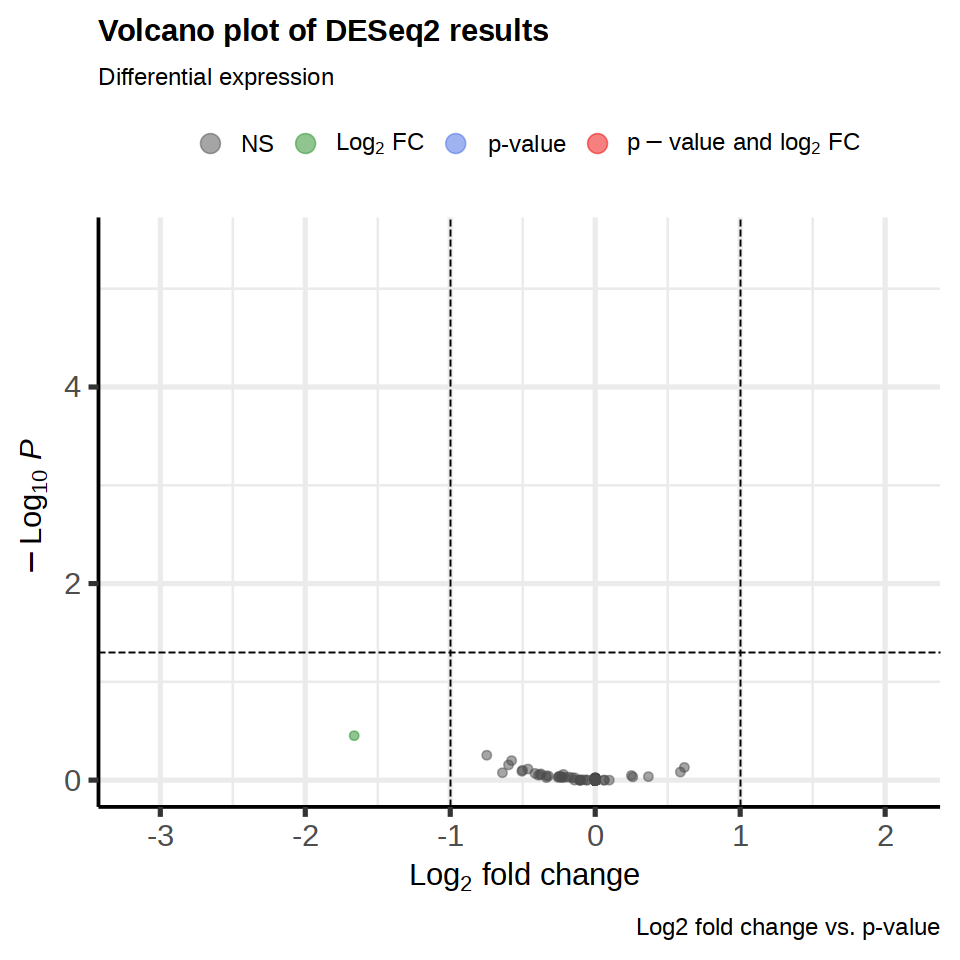

In [96]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



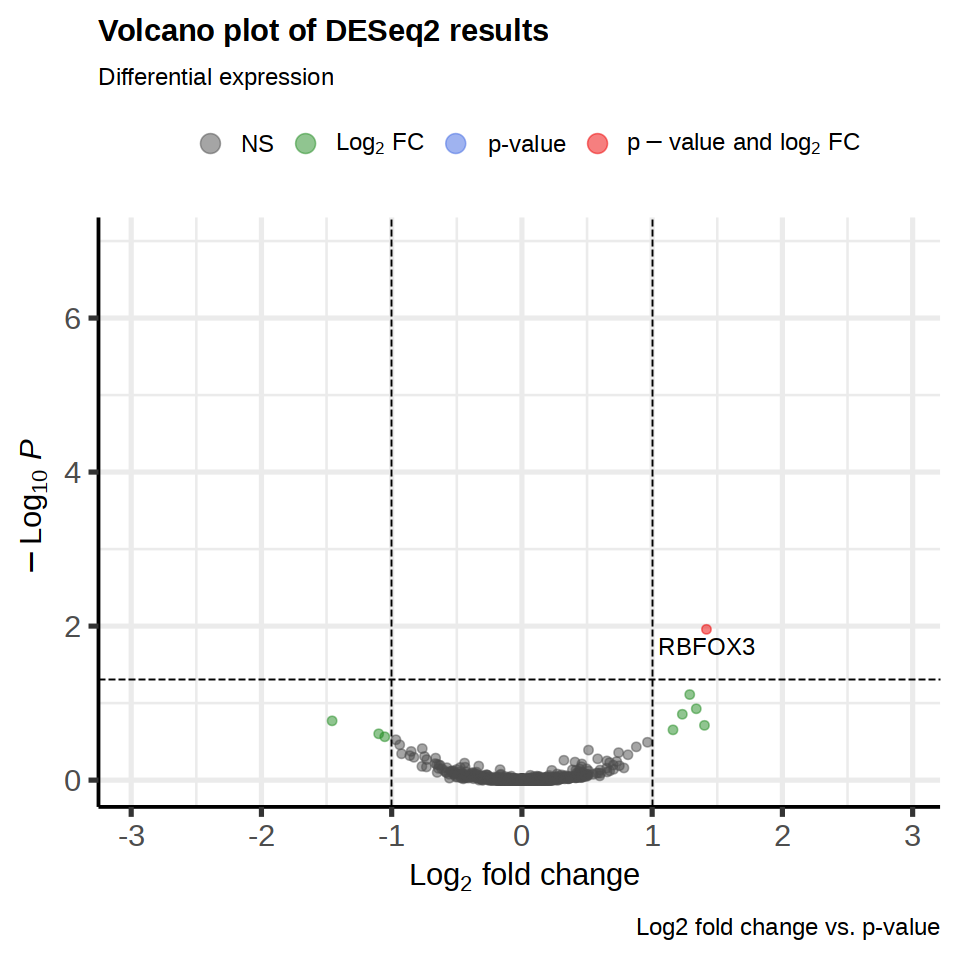

In [93]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



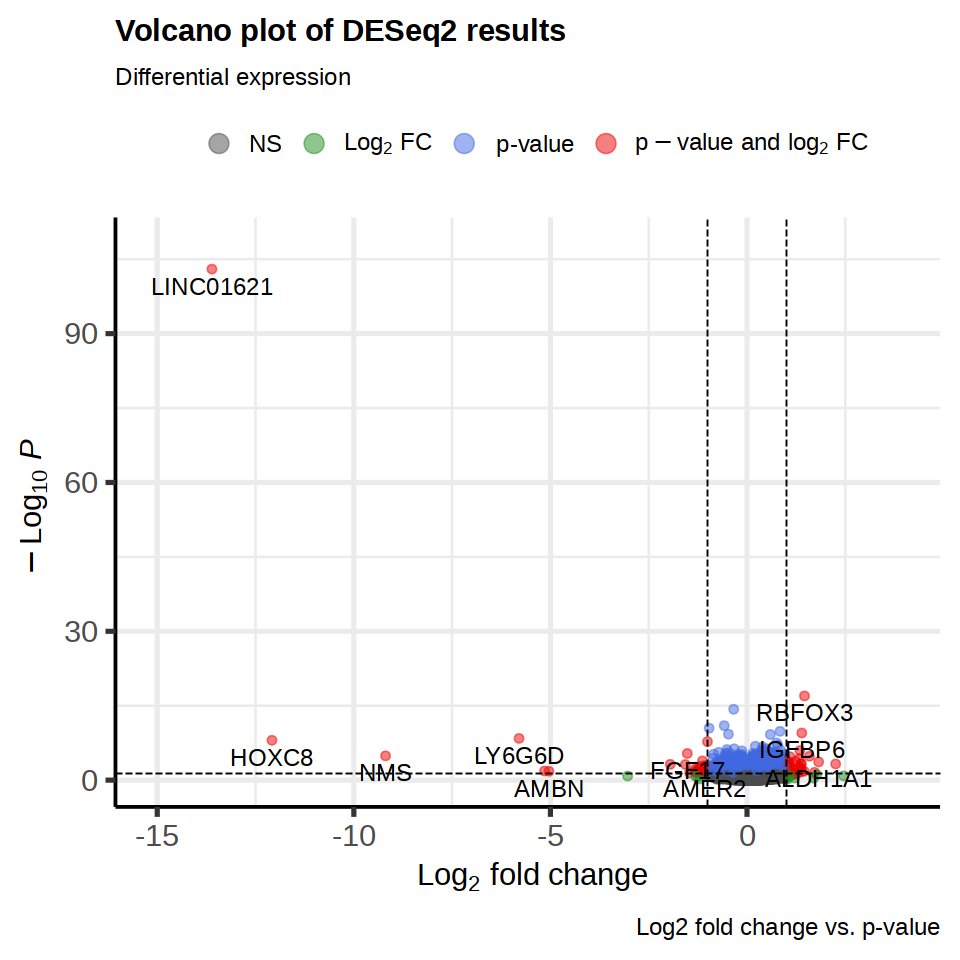

In [82]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')


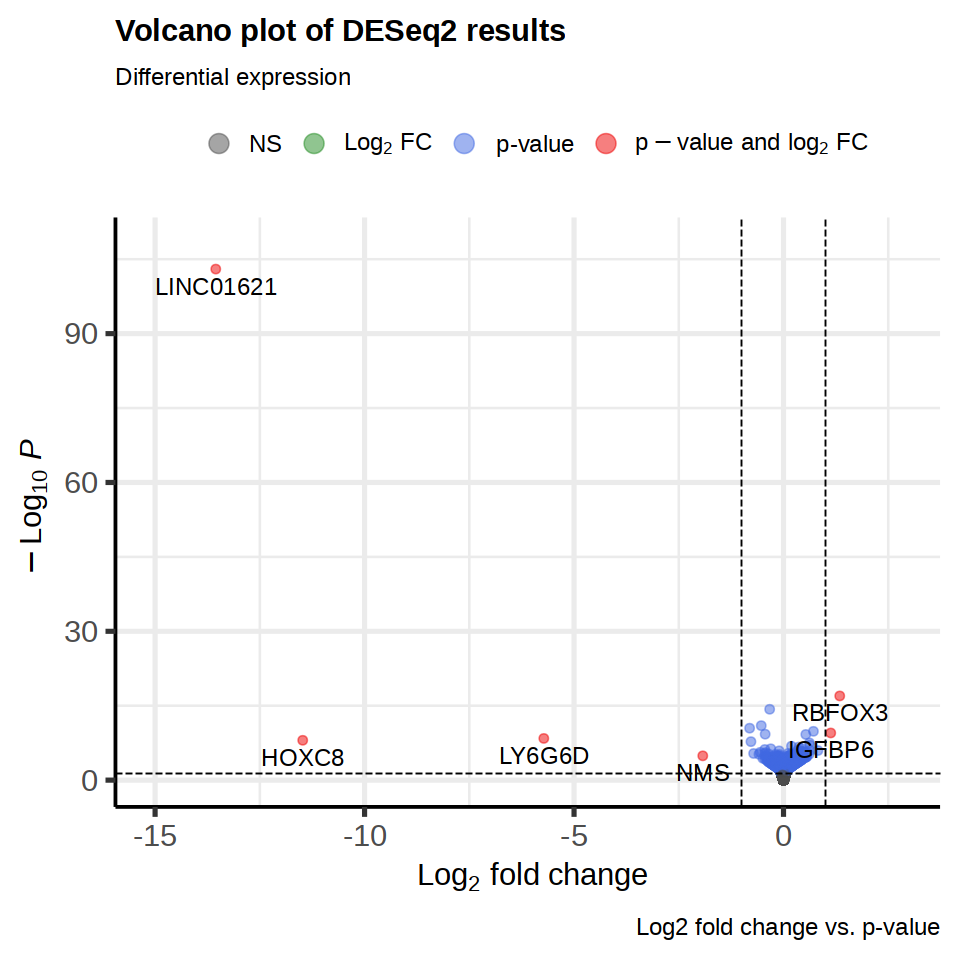

In [81]:
# Get results
res <- resAshT

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')


In [93]:
table(vsd_l@colData$M_RA)


-0.247023184533617 -0.195228000679794  0.270928654004612   4.93249520084867 
               151                  8                 16                  7 

In [56]:
table(vsd@colData$M_RA)


-0.42279543647209 0.882246098889301  2.08895894809182  3.33725699238602 
              151                 8                16                 7 